In [ ]:
!pip install nltk==3.8.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.9.1
    Uninstalling nltk-3.9.1:
      Successfully uninstalled nltk-3.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
textblob 0.19.0 requires nltk>=3.9, but you have nltk 3.8.1 which is incompatible.


In [ ]:

!pip install -q 'tensorflow-text==2.11.*'
!pip install -q tensorflow_datasets
!pip install -q einops

ERROR: Could not find a version that satisfies the requirement tensorflow-text==2.11.* (from versions: 2.12.0rc0, 2.12.0, 2.12.1, 2.13.0rc0, 2.14.0rc0, 2.14.0, 2.15.0rc0, 2.15.0, 2.16.0rc0, 2.16.1, 2.17.0rc0, 2.17.0, 2.18.0rc0, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow-text==2.11.*


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import collections
import time
import string
import re
import einops
from tqdm.auto import tqdm
from PIL import Image
import nltk
from nltk.util import ngrams

import tensorflow as tf
import tensorflow_text as tf_text
import tensorflow_datasets as tfds




In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def get_data(path = 'flickr8k'):
    path = pathlib.Path('flickr8k')

    tf.keras.utils.get_file(origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
                            cache_dir = '.',
                            cache_subdir = path,
                            extract = True)

    tf.keras.utils.get_file(origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
                            cache_dir = '.',
                            cache_subdir = path,
                            extract = True)

def get_dataset(path = 'flickr8k'):
    path = pathlib.Path('flickr8k')
    captions = (path/'Flickr8k_text.zip/Flickr8k.token.txt').read_text().splitlines()
    captions = [cap.split('\t') for cap in captions]
    captions = [(img_path.split('#')[0], cap) for (img_path, cap) in captions]
    cap_dict = collections.defaultdict(list)
    for img_path, cap in captions:
        cap_dict[img_path].append(cap)

    train_imgs_path = (path/'Flickr8k_text.zip/Flickr_8k.trainImages.txt').read_text().splitlines()
    test_imgs_path = (path/'Flickr8k_text.zip/Flickr_8k.testImages.txt').read_text().splitlines()

    train_caps = [(str(path/'Flickr8k_Dataset.zip/Flicker8k_Dataset'/img_path), cap_dict[img_path]) for img_path in train_imgs_path]
    test_caps = [(str(path/'Flickr8k_Dataset.zip/Flicker8k_Dataset'/img_path), cap_dict[img_path]) for img_path in test_imgs_path]

    train_raw = tf.data.experimental.from_list(train_caps)
    test_raw = tf.data.experimental.from_list(test_caps)

    return train_raw, test_raw

In [ ]:
get_data()

1115419746/1115419746 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
2340801/2340801 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
train_raw, test_raw = get_dataset()

In [ ]:
print(len(train_raw), len(test_raw))
print(train_raw.element_spec)

for img_path, captions in train_raw.take(1):
    break

print(img_path)
print(captions)

6000 1000
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.string, name=None))
tf.Tensor(b'flickr8k/Flickr8k_Dataset.zip/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


In [ ]:
image_shape = (224, 224, 3)

In [ ]:
feature_extractor = tf.keras.applications.MobileNetV3Small(input_shape = image_shape, include_preprocessing = True, include_top = False)
feature_extractor.trainable = False

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, image_shape[:-1])
    return img

In [ ]:
img = load_img(img_path.numpy().decode('utf-8'))
print(img.shape)
print(feature_extractor(img[tf.newaxis, ...]).shape)

(224, 224, 3)
(1, 7, 7, 576)


In [ ]:
def standardize(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, f'[{re.escape(string.punctuation)}]', '')
    text = tf.strings.join(['[START]',text,'[END]'], separator = ' ')
    return text

In [ ]:
standardize('A black dog is running after a white dog in the snow .')

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] a black dog is running after a white dog in the snow  [END]'>

In [ ]:
vocab_size = 5000
vectorizer = tf.keras.layers.TextVectorization(max_tokens = vocab_size,
                                               standardize = standardize,
                                               ragged = True)

vectorizer.adapt(train_raw.map(lambda img_path, cap: cap).unbatch().batch(1024))

In [ ]:
print(vectorizer.get_vocabulary()[:10])

['', '[UNK]', np.str_('a'), np.str_('[START]'), np.str_('[END]'), np.str_('in'), np.str_('the'), np.str_('on'), np.str_('is'), np.str_('and')]


In [ ]:

text_to_id_vectorizer = tf.keras.layers.StringLookup(vocabulary = vectorizer.get_vocabulary(), mask_token = '')
id_to_text_vectorizer = tf.keras.layers.StringLookup(vocabulary = vectorizer.get_vocabulary(), mask_token = '', invert = True)

In [ ]:
def id_to_text(token_ids, reserved_tokens = ['', '[UNK]', '[START]', '[END]']):
    words = id_to_text_vectorizer(token_ids)
    bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != '[UNK]']
    bad_tokens_re = '|'.join(bad_tokens)
    bad_mask = tf.strings.regex_full_match(words, bad_tokens_re)
    words = tf.ragged.boolean_mask(words, ~bad_mask)

    return tf.strings.reduce_join(words, axis = -1, separator = ' ')

def serialize_data(images, captions):
    captions_shape = einops.parse_shape(captions, 'b c')
    captions = einops.rearrange(captions, 'b c -> (b c)')
    images = einops.repeat(images, 'b ...  -> (b c) ...', c = captions_shape['c'])
    return images, captions

In [ ]:
for img, cap in train_raw.batch(1024).take(1):
    break

print(img.shape)
print(cap.shape)
img_serialize, cap_serialize = serialize_data(img, cap)
print(img_serialize.shape, cap_serialize.shape)

(1024,)
(1024, 5)
(5120,) (5120,)


In [ ]:
def prepare_batch(img, cap):
    cap_tokenized = vectorizer(cap)
    cap_tokenized_in = cap_tokenized[:, :-1]
    cap_tokenized_out = cap_tokenized[:, 1:]

    return (img, cap_tokenized_in.to_tensor()), cap_tokenized_out.to_tensor()

In [ ]:

def save_dataset(raw_ds, file_path, image_feature_extractor, vectorizer, shards = 20, batch_size = 64):
    raw_ds = (raw_ds
              .map(lambda img_path, cap: (load_img(img_path), cap), tf.data.AUTOTUNE)
              .batch(batch_size))

    def gen():
        for (img, cap) in tqdm(raw_ds):
            img_features = image_feature_extractor(img)
            img_features, cap = serialize_data(img_features, cap)

            yield img_features, cap

    ds = tf.data.Dataset.from_generator(gen,
                                        output_signature = (
                                            tf.TensorSpec(shape = image_feature_extractor.output_shape),
                                            tf.TensorSpec(shape = (None,), dtype = tf.string)
                                        ))

    ds = (ds
          .map(prepare_batch, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(1000))

    def shard_func(i, data):
        return i % shards

    ds.enumerate().save(file_path, shard_func = shard_func)

In [ ]:
%%time
save_dataset(train_raw, 'train_cache', feature_extractor, vectorizer)
save_dataset(test_raw, 'test_cache', feature_extractor, vectorizer)

  0%|          | 0/94 [00:01<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 3min 1s, sys: 20.5 s, total: 3min 22s
Wall time: 2min 52s


In [ ]:
def load_dataset(file_path, batch_size = 64, cycle_length = 2):
    def reader_func(ds):
        ds = ds.shuffle(1000)
        return ds.interleave(lambda x: x, cycle_length = cycle_length)

    def drop_index(i, x):
        return x

    ds = tf.data.Dataset.load(file_path, reader_func = reader_func)

    ds = (ds
          .map(drop_index)
          .shuffle(1000)
          .padded_batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))
    return ds

In [ ]:
batch_size = 64
train_ds = load_dataset('train_cache', batch_size)
test_ds = load_dataset('test_cache', batch_size)

In [ ]:
for (img, cap), cap_labels in train_ds.take(1):
    break

print(img.shape)
print(cap.shape)
print(cap_labels.shape)

print(cap[0])
print(cap_labels[0])

(64, 7, 7, 576)
(64, 37)
(64, 37)
tf.Tensor(
[   3    6   26    9   15    1  108    2   28 1134    5   77   68    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)
tf.Tensor(
[   6   26    9   15    1  108    2   28 1134    5   77   68    4    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)


In [ ]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
def positional_encoding(length, depth):
    pos = tf.cast(tf.range(length)[:, tf.newaxis], tf.float32)
    dep = tf.cast(tf.range(depth)[tf.newaxis, :], tf.float32)
    dep = ((dep // 2)*2)/tf.cast(depth, tf.float32)

    angle_rates = 1 / (10000**dep)
    angle_rads = pos*angle_rates

    out = tf.Variable(tf.zeros((length, depth)))
    out[:, 0::2].assign(tf.math.sin(angle_rads[:, 0::2]))
    out[:, 1::2].assign(tf.math.cos(angle_rads[:, 1::2]))

    return out[tf.newaxis, ...]

In [ ]:
sample_enc = positional_encoding(length = 2048, depth = 512)[0]

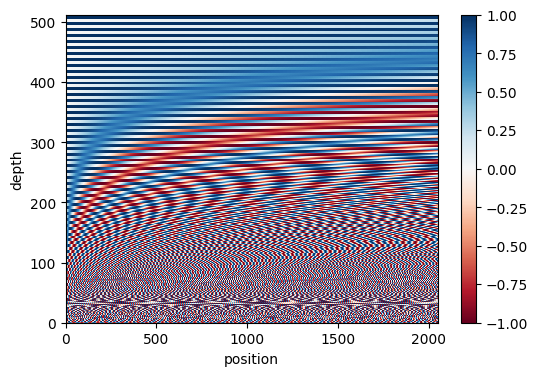

In [ ]:
plt.figure(figsize = (6, 4))
plt.pcolormesh(tf.transpose(sample_enc), cmap = 'RdBu')
plt.xlabel('position')
plt.ylabel('depth')
plt.colorbar()
plt.show();

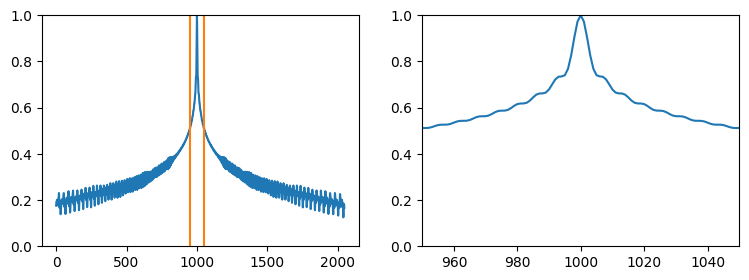

In [ ]:
p_norm = tf.linalg.l2_normalize(sample_enc[1000][tf.newaxis, :])
sample_enc_norm = tf.linalg.l2_normalize(sample_enc, axis = 1)
dots = tf.linalg.matmul(sample_enc_norm, p_norm, transpose_b = True)

plt.figure(figsize = (9, 3))
plt.subplot(1, 2, 1)
plt.plot(dots)
plt.ylim([0, 1])
plt.plot([950, 950, float('nan'), 1050, 1050], [0, 1, float('nan'), 0, 1])

plt.subplot(1, 2, 2)
plt.plot(dots)
plt.ylim([0, 1])
plt.xlim([950, 1050])
plt.show()

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero = True)
        self.pos_enc = positional_encoding(length = 2048, depth = d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x_emb = self.embedding(x)
        x_pos_enc = self.pos_enc[:, :length, :]

        x_emb *= tf.cast(self.d_model, tf.float32)
        x_emb += x_pos_enc

        return x_emb

In [ ]:
sample_pos_emb = PositionalEmbedding(vocab_size, d_model = 512)
cap_emb = sample_pos_emb(cap)
print(cap_emb.shape)


(64, 37, 512)


In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

In [ ]:
class CausalAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query = x,
                               key = x,
                               value = x,
                               use_causal_mask = True)

        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [ ]:
sample_csa = CausalAttention(num_heads = 8, key_dim = 512)
sample_csa_out = sample_csa(cap_emb)
print(sample_csa_out.shape)

(64, 37, 512)


In [ ]:
class CrossAttention(BaseAttention):
    def call(self, context, x):
        attn_out, attn_scores = self.mha(query = x,
                                         key = context,
                                         value = context,
                                         return_attention_scores = True)

        self.last_attention_scores = attn_scores

        x = self.add([x, attn_out])
        x = self.layernorm(x)
        return x

In [ ]:
img_ = einops.rearrange(img, 'b h w c -> b (h w) c')
print(img.shape, img_.shape)

sample_ca = CrossAttention(num_heads = 8, key_dim = 512)
sample_ca_out = sample_ca(context = img_, x = sample_csa_out)
print(sample_ca_out.shape)

(64, 7, 7, 576) (64, 49, 576)
(64, 37, 512)


In [ ]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate = 0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation = 'relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(rate = dropout_rate)
        ])

        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)
        return x


In [ ]:
sample_ffn = FeedForward(d_model = 512, dff = 2048)
sample_ffn_out = sample_ffn(sample_ca_out)
print(sample_ffn_out.shape)


(64, 37, 512)


In [ ]:
class GatedFusion(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super().__init__()

        self.proj_x = tf.keras.layers.Dense(d_model)
        self.proj_context = tf.keras.layers.Dense(d_model)
        self.gate = tf.keras.layers.Dense(d_model, activation='sigmoid')

    def call(self, x, context):
        """
        x: output from cross attention (shape: batch_size, seq_len, d_model)
        context: original image features (shape: batch_size, seq_len, feature_dim)
        """

        x_proj = self.proj_x(x)
        context_proj = self.proj_context(context)

        gate_values = self.gate(context_proj)


        fused_output = gate_values * x_proj + (1 - gate_values) * context_proj

        return fused_output

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, num_heads, dropout_rate=0.1):
        super().__init__()
        self.causal_attention = CausalAttention(num_heads=num_heads,
                                              key_dim=d_model,
                                              dropout=dropout_rate)
        self.cross_attention = CrossAttention(num_heads=num_heads,
                                            key_dim=d_model,
                                            dropout=dropout_rate)
        self.gated_fusion = GatedFusion(d_model)
        self.ffn = FeedForward(d_model=d_model,
                             dff=dff,
                             dropout_rate=dropout_rate)
        self.last_attention_scores = None

    def call(self, context, x):
        x = self.causal_attention(x)

        # Cross attention
        cross_attn_out = self.cross_attention(context=context, x=x)

        # Get the dynamic sequence length
        seq_len = tf.shape(cross_attn_out)[1]

        # Gated fusion between cross attention output and original context
        if context.shape[1] != cross_attn_out.shape[1]:
            # Average pool context features to match sequence length
            pooled_context = tf.reduce_mean(context, axis=1, keepdims=True)
            pooled_context = tf.tile(pooled_context, [1, seq_len, 1])
        else:
            pooled_context = context

        fused_output = self.gated_fusion(cross_attn_out, pooled_context)

        x = self.ffn(fused_output)
        self.last_attention_scores = self.cross_attention.last_attention_scores

        return x

In [ ]:
sample_decoder_layer = DecoderLayer(d_model = 512, dff = 2048, num_heads = 8, dropout_rate = 0.2)
sample_decoder_layer_out = sample_decoder_layer(context = img_, x = cap_emb)
print(sample_decoder_layer_out.shape)

(64, 37, 512)


In [ ]:
class OutputLayer(tf.keras.layers.Layer):
    def __init__(self, vocab, bad_tokens = ('', '[UNK]', '[START]')):
        super().__init__()
        self.vocab = vocab
        self.bad_tokens = bad_tokens
        self.bias = 0
        self.dense_layer = tf.keras.layers.Dense(len(vocab), activation = tf.nn.log_softmax)

    def adapt(self, cap_ds):
        word_idx = {word : idx for idx, word in enumerate(self.vocab)}
        counts = collections.Counter()
        for tokens in cap_ds:
            counts.update(tokens.numpy().flatten())

        counts_arr = np.zeros((len(self.vocab), ))
        for token_id, cnt in counts.items():
            counts_arr[token_id] = cnt

        bad_indices = np.array([word_idx[word] for word in self.bad_tokens])
        counts_arr[bad_indices] = 0

        counts_prob = counts_arr / counts_arr.sum()
        counts_prob[counts_arr == 0] = 1
        log_p = np.log(counts_prob)

        entropy = (-counts_prob*log_p).sum()

        print(f'uniform_entropy : {np.log(len(self.vocab))}')
        print(f'curr_entropy : {entropy}')
        log_p[counts_arr == 0] = -1e9

        self.bias = log_p[tf.newaxis, tf.newaxis, :]

    def call(self, x):
        return self.dense_layer(x) + self.bias

In [ ]:
vocab = vectorizer.get_vocabulary()
sample_output_layer = OutputLayer(vocab)
sample_output_layer.adapt(train_ds.map(lambda img, cap: cap))
sample_output_layer_out = sample_output_layer(sample_decoder_layer_out)
print(sample_output_layer_out.shape)

uniform_entropy : 8.517193191416238
curr_entropy : 5.292547935444457
(64, 37, 5000)


In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_heads, d_model, dff, dropout_rate = 0.1):
        super().__init__()
        self.num_layers = num_layers

        self.positional_embedding = PositionalEmbedding(vocab_size, d_model)
        self.decoder_layers = [DecoderLayer(d_model, dff, num_heads, dropout_rate) for _ in range(num_layers)]
        self.last_attention_scores = None

    def call(self, context, x):
        x = self.positional_embedding(x)
        for i in range(self.num_layers):
            x = self.decoder_layers[i](context = context, x = x)

        self.last_attention_scores = self.decoder_layers[-1].last_attention_scores
        return x

In [ ]:
for (img, cap), cap_labels in train_ds.take(1):
    break

print(img.shape)
print(cap.shape)
print(cap_labels.shape)

img_features = einops.rearrange(img, 'b h w c -> b (h w) c')
print(img_features.shape)

(64, 7, 7, 576)
(64, 37)
(64, 37)
(64, 49, 576)


In [ ]:
%%time
sample_decoder = Decoder(num_layers = 6, num_heads = 8, d_model = 512, dff = 2048)
sample_decoder_output = sample_decoder(context = img_features, x = cap)
print(sample_decoder_output.shape)
print(sample_decoder.last_attention_scores.shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_attention_2' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 37, 512)
(64, 8, 37, 49)
CPU times: user 39.3 s, sys: 4.96 s, total: 44.2 s
Wall time: 29.7 s


In [ ]:
class Captioner(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, vectorizer, feature_extractor, output_layer, num_layers, num_heads, d_model, dff, pred_max_len =  50, dropout_rate = 0.1):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.vectorizer = vectorizer
        self.output_layer = output_layer
        self.decoder = Decoder(num_layers, num_heads, d_model, dff, dropout_rate)
        self.max_len = pred_max_len
        self.vocab = self.vectorizer.get_vocabulary()

    def call(self, inputs):
        context, cap = inputs
        if context.shape[-1] == 3:
            context = self.feature_extractor(context)
        context = einops.rearrange(context, 'b h w c -> b (h w) c')

        if cap.dtype == tf.string:
            cap = self.vectorizer([cap])


        x = self.decoder(context = context, x = cap)
        x = self.output_layer(x)
        return x

In [ ]:
%%time
sample_captioner = Captioner(vectorizer = vectorizer,
                             feature_extractor = feature_extractor,
                             output_layer = sample_output_layer,
                             num_layers = 6,
                             num_heads = 8,
                             d_model = 512,
                             dff = 2048,
                             dropout_rate = 0.2)

print(sample_captioner((img, cap)).shape)
print(cap_labels.shape)
print(sample_captioner.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_attention_8' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 37, 5000)
(64, 37)


Model: "captioner"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (OutputLayer)      │ ?                      │     2,565,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Decoder)             │ ?                      │   124,063,744 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,567,864 (486.63 MB)

 Trainable params: 126,628,744 (483.05 MB)

 Non-trainable params: 939,120 (3.58 MB)

None
CPU times: user 42.2 s, sys: 5.61 s, total: 47.8 s
Wall time: 32.9 s


In [ ]:
d_model = 128
dff = 128
dropout_rate = 0.4
num_layers = 2
num_heads = 2
output_layer = OutputLayer(vocab)
output_layer.adapt(train_ds.map(lambda img_feature, cap: cap))

uniform_entropy : 8.517193191416238
curr_entropy : 5.292547935444457


In [ ]:
for (img_feature, cap), cap_labels in train_ds.take(1):
    break
print(img_feature.shape)
print(cap.shape)
print(cap_labels.shape)

(64, 7, 7, 576)
(64, 37)
(64, 37)


In [ ]:
%%time
captioner_model = Captioner(vectorizer = vectorizer,
                            feature_extractor = feature_extractor,
                            output_layer = output_layer,
                            num_layers = num_layers,
                            num_heads = num_heads,
                            d_model = d_model,
                            dff = dff,
                            dropout_rate = dropout_rate)

print(captioner_model((img_feature, cap), training = False).shape)
captioner_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_attention_14' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 37, 5000)


Model: "captioner_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer_1 (OutputLayer)    │ ?                      │       645,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Decoder)             │ ?                      │     1,907,968 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,492,088 (13.32 MB)

 Trainable params: 2,552,968 (9.74 MB)

 Non-trainable params: 939,120 (3.58 MB)

CPU times: user 3.84 s, sys: 542 ms, total: 4.39 s
Wall time: 4.25 s


In [ ]:
@Captioner.add_method
def generate_text(self, img, temperature = 0.5):
    if img.shape[-1] == 3:
        img = self.feature_extractor(img)
    start_token = text_to_id_vectorizer([['[START]']])

    start_idx = self.vocab.index('[START]')
    end_idx = self.vocab.index('[END]')

    for i in range(self.max_len):
        preds = self((img, start_token))
        preds = preds[:, -1, :]
        if temperature == 0.0:
            pred_idx = tf.argmax(preds, axis = -1)[:, tf.newaxis]
        else:
            preds /= temperature
            pred_idx = tf.random.categorical(preds, num_samples = 1)

        start_token = tf.concat([start_token, pred_idx], axis = -1)

        if pred_idx[0][0] == end_idx:
            break

    return id_to_text(start_token).numpy()[0].decode('utf-8')


In [ ]:

def brevity_penalty(can, ref):
    can_tokens = nltk.word_tokenize(can)
    ref_tokens = nltk.word_tokenize(ref)
    if len(can_tokens) == 0:
        return 0.0
    return min(1, np.exp(1 - (len(ref_tokens) / len(can_tokens))))

def precision(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(can_n.values())

    if total == 0:
        return 0

    for n_g in can_n:
        if n_g in ref_n:
            can_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            can_n[n_g] = 0
    return sum(can_n.values()) / total

def bleu_score(can , ref, n_gram_range = 2):
    precisions = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        precisions.append(precision(can, ref, n))
    precisions = np.array(precisions)

    if 0 in precisions:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(precisions).mean())

def recall(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(ref_n.values())

    if total == 0:
        return 0

    for n_g in ref_n:
        if n_g in can_n:
            ref_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            ref_n[n_g] = 0
    return sum(ref_n.values()) / total

def rouge_score(can , ref, n_gram_range = 2):
    recalls = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        recalls.append(recall(can, ref, n))
    recalls = np.array(recalls)

    if 0 in recalls:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(recalls).mean())

In [ ]:
@Captioner.add_method
def f_score(self, can, refs, n_gram_range = 1):
    b_scores = [bleu_score(can, ref, n_gram_range) for ref in refs]
    r_scores = [rouge_score(can, ref, n_gram_range)  for ref in refs]
    f_vals = []
    for b_score, r_score in zip(b_scores, r_scores):
        if b_score + r_score == 0:
            return 0
        f_vals.append((2*b_score*r_score) / (b_score + r_score))

    return max(f_vals)

In [ ]:
def masked_loss(labels, preds):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')
    loss = tf.cast(loss_fn(labels, preds), tf.float32)
    mask = ((labels != 0) & (loss < 1e8))
    mask = tf.cast(mask, tf.float32)
    loss *= mask
    return tf.math.reduce_sum(loss) / tf.math.reduce_sum(mask)

def masked_accuracy(labels, preds):
    preds = tf.cast(tf.argmax(preds, axis = -1), tf.float32)
    labels = tf.cast(labels, tf.float32)
    mask = tf.cast(labels != 0, tf.float32)
    acc = tf.cast(preds == labels, tf.float32)
    acc *= mask
    return tf.math.reduce_sum(acc) / tf.math.reduce_sum(mask)

In [ ]:
for (img, cap), cap_labels in train_ds.take(1):
    break
print(img.shape)
print(cap.shape)
print(cap_labels.shape)

preds = captioner_model((img, cap))
print(preds.shape)

print(masked_loss(cap, preds))
print(masked_accuracy(cap, preds))

(64, 7, 7, 576)
(64, 37)
(64, 37)
(64, 37, 5000)
tf.Tensor(5.569868, shape=(), dtype=float32)
tf.Tensor(0.12978142, shape=(), dtype=float32)


tf.Tensor(b'flickr8k/Flickr8k_Dataset.zip/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
(224, 224, 3)
['A black dog is running after a white dog in the snow .', 'Black dog chasing brown dog through snow', 'Two dogs chase each other across the snowy ground .', 'Two dogs play together in the snow .', 'Two dogs running through a low lying body of water .']


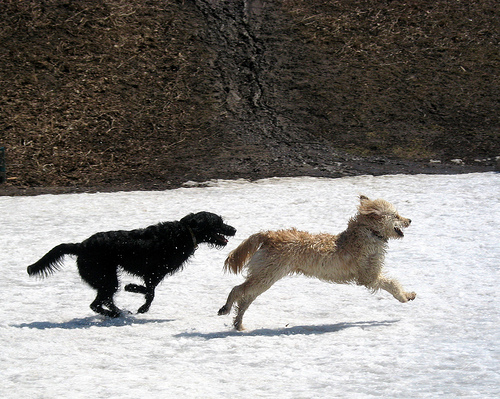

In [ ]:
for img_path, caps in train_raw.take(1):
    break
print(img_path)
img = load_img(img_path)
print(img.shape)
caps = [cap.numpy().decode('utf-8') for cap in caps]
print(caps)
Image.open(img_path.numpy().decode('utf-8'))

In [ ]:
class GenerateText(tf.keras.callbacks.Callback):
    def __init__(self, img = img):
        self.image = img[tf.newaxis, ...]
        self.caps = caps

    def on_epoch_end(self, epochs = None, logs = None):
        print('\n')
        for temp in (0, 0.5, 1):
            gen_text = self.model.generate_text(self.image)
            f_val = self.model.f_score(gen_text, self.caps, n_gram_range = 1)
            print(f'Generated_text: {gen_text}, \t f_score: {f_val}')

In [ ]:
# Initial setup with feature extractor frozen
captioner_model.feature_extractor.trainable = False

# Define both optimizers upfront
initial_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
unfrozen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

class UnfreezeFeatureExtractorCallback(tf.keras.callbacks.Callback):
    def __init__(self, unfreeze_epoch=21):
        super().__init__()
        self.unfreeze_epoch = unfreeze_epoch

    def on_epoch_begin(self, epoch, logs=None):
        if epoch == self.unfreeze_epoch:
            print(f"\nEpoch {epoch+1}: Unfreezing feature extractor weights")
            self.model.feature_extractor.trainable = True
            self.model.optimizer = unfrozen_optimizer

# # Compile initially
# captioner_model.compile(
#     loss=masked_loss,
#     optimizer=initial_optimizer,
#     metrics=[masked_accuracy]
# )

callbacks = [
    GenerateText(),
    UnfreezeFeatureExtractorCallback(unfreeze_epoch=21),
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
]



In [ ]:
# Run training
hist = captioner_model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.4375 - masked_accuracy: 0.4821

Generated_text: two dogs run through the snow, 	 f_score: 0
Generated_text: two dogs running through the snow, 	 f_score: 0
Generated_text: two dogs play in the snow, 	 f_score: 0
100/100 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - loss: 2.4377 - masked_accuracy: 0.4820 - val_loss: 3.0458 - val_masked_accuracy: 0.3852
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.4698 - masked_accuracy: 0.4737

Generated_text: two dogs running through the snow, 	 f_score: 0
Generated_text: dogs play in the snow, 	 f_score: 0
Generated_text: a dog is jumping up in the snow, 	 f_score: 0.30769230769230765
100/100 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - loss: 2.4697 - masked_accuracy: 0.4737 - val_loss: 3.0156 - val_masked_accuracy: 0.3874
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.4494 - masked_accuracy: 0.4776

Generated_text: two dogs play in the snow, 	 f_score: 0
Generated_text: two dogs 

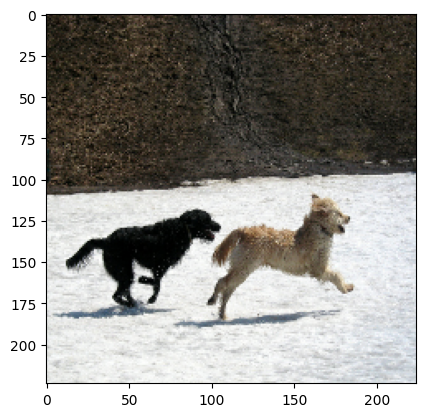

Generated Caption: two dogs are playing in the snow


In [ ]:
for img_path, caps in train_raw.batch(4).take(1):
    break

img = load_img(img_path[0].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

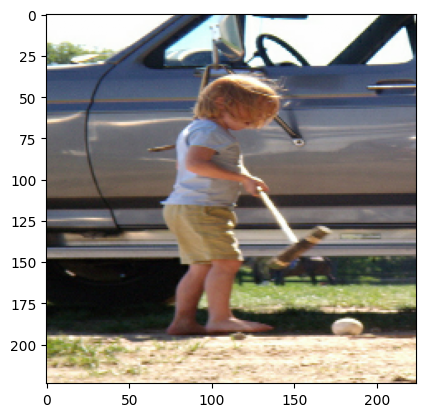

Generated Caption: a girl is walking on the sidewalk


In [ ]:
img = load_img(img_path[1].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

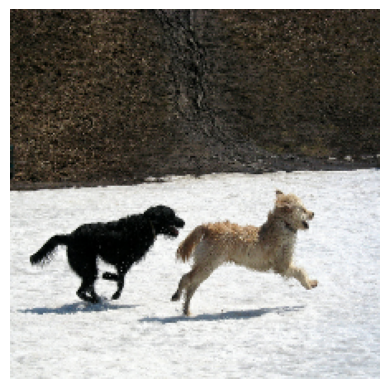

two dogs are running through the snow


In [ ]:
for img_path, cap in train_raw.take(1):
    break
img = load_img(img_path)
cap_gen = captioner_model.generate_text(img[tf.newaxis, ...])

plt.imshow(img/255)
plt.axis('off')
plt.show()
print(cap_gen)

In [ ]:
cap_gen_tokens = cap_gen.split() + ['[END]']
print(len(cap_gen_tokens))


8


In [ ]:
attn_scores = captioner_model.decoder.last_attention_scores
print(attn_scores.shape)
attn_maps = einops.reduce(attn_scores, 'b num_heads seq_len (h w) -> seq_len h w', h = 7, w = 7, reduction = 'mean')
print(attn_maps.shape)

(1, 2, 8, 49)
(8, 7, 7)


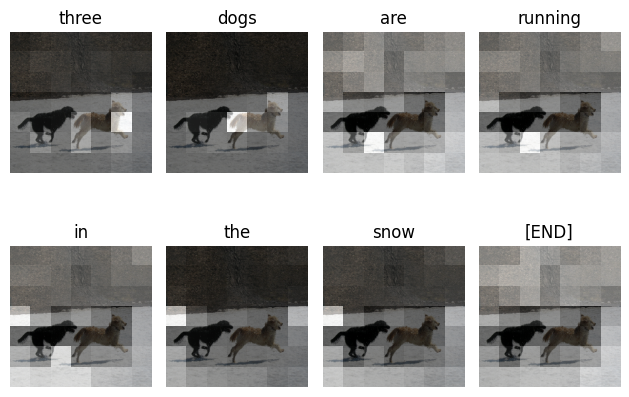

In [ ]:
len_result = len(attn_maps)
col_len = int(np.ceil(len_result/2))
row_len = 2

for i in range(len_result):
    ax = plt.subplot(row_len, col_len, i+1)
    img_plot = ax.imshow(img/255)
    plt.title(cap_gen_tokens[i])
    ax.imshow(attn_maps[i], cmap = 'gray', alpha = 0.6, extent = img_plot.get_extent(), clim = [0, np.max(attn_maps[i])])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:

@Captioner.add_method
def show_attention(self, img, temperature = 0.5):
    gen_text = self.generate_text(img = img[tf.newaxis, ...], temperature = temperature)
    cap_gen_tokens = cap_gen.split() + ['[END]']
    # Here we are adding [END] token as while printing text using id_to_text, it filters out [END] token even though it is generated.
    attn_scores = captioner_model.decoder.last_attention_scores
    attn_maps = einops.reduce(attn_scores, 'b num_heads seq_len (h w) -> seq_len h w', h = 7, w = 7, reduction = 'mean')

    len_result = len(attn_maps)
    col_len = int(np.ceil(len_result/2))
    row_len = 2

    for i in range(len_result):
        ax = plt.subplot(row_len, col_len, i+1)
        img_plot = ax.imshow(img/255)
        plt.title(cap_gen_tokens[i])
        ax.imshow(attn_maps[i], cmap = 'gray', alpha = 0.6, extent = img_plot.get_extent(), clim = [0, np.max(attn_maps[i])])
        plt.axis('off')


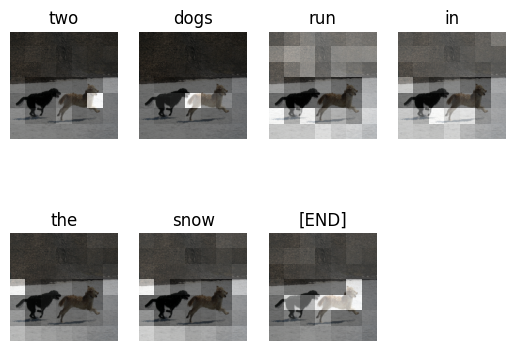

In [ ]:
captioner_model.show_attention(img)

4.415406219270391
9.032439156848193
14.779236822876337
19.801991682209987
23.577818438843867
28.545560647101833
33.64670006042048
38.74387130622607
44.44548192651365
49.15006578093163
53.77746375644829
59.04829864451643
63.47435438283091
68.65644426013066
72.81967689423706
77.60457005343417
82.80525636144607
87.48455158194709
91.62499318579671
95.5773084641211
99.95674733703058
104.53148276457465
109.32656499845544
113.8464710306577
118.37486478840478
123.83353658318406
128.16961947064522
132.40180840094177
137.3200007780255
142.30858574414853
146.8293462699589
151.84748228746219
157.35935702733246
161.33930938218157
166.34209341060165
171.8366551486284
177.11608732531346
181.5420692096093
186.8418920331643
191.98888550214002
196.60680225222794
203.12785820686096
207.33555943564903
211.36413530107103
216.13910386698757
221.26167841184014
225.4739926145905
230.20450601635102
235.16192516201377
240.4902915774006
245.96096840651023
250.6797204380628
255.1617476357999
259.9140806216398
264

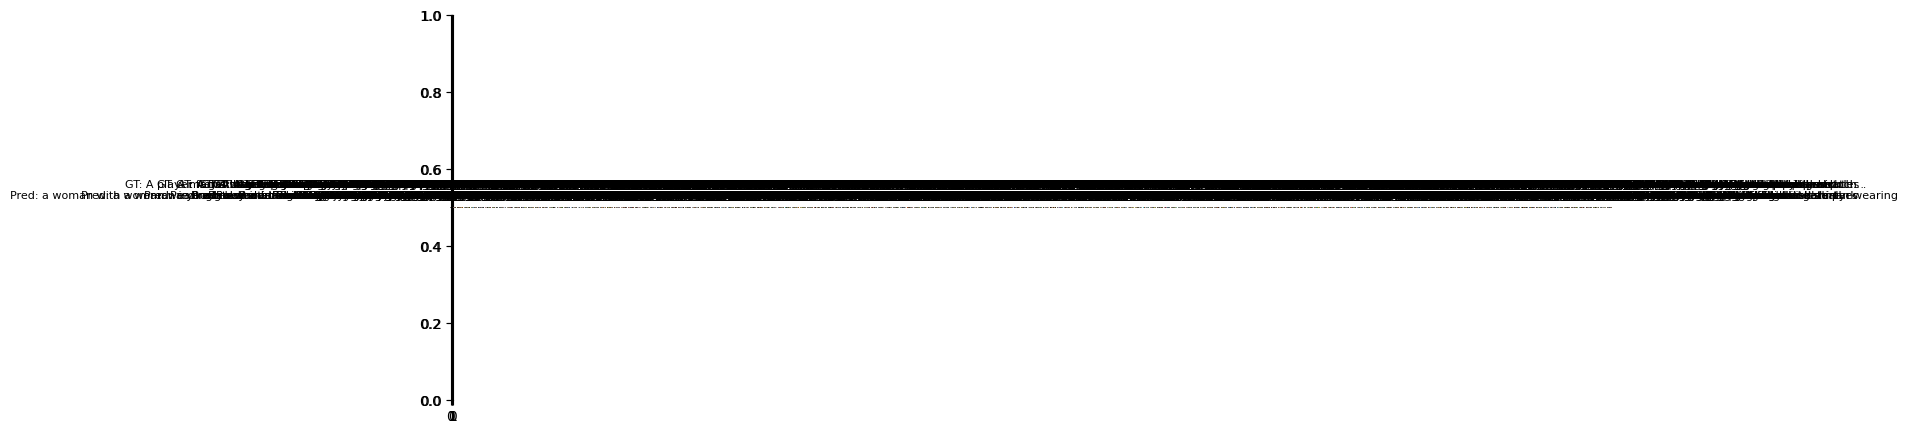

In [ ]:
import builtins
sum = builtins.sum
import math
from collections import Counter

def get_ngrams(sentence, n):
    """Returns a list of n-grams from a given sentence."""
    words = sentence.split()
    return [' '.join(words[i:i+n]) for i in range(len(words) - n + 1)]

def modified_precision(references, hypothesis, n):
    """Computes the modified n-gram precision."""
    hyp_ngrams = Counter(get_ngrams(hypothesis, n))
    max_ref_ngrams = Counter()

    for ref in references:
        ref_ngrams = Counter(get_ngrams(ref, n))
        for ngram in ref_ngrams:
            max_ref_ngrams[ngram] = max(max_ref_ngrams[ngram], ref_ngrams[ngram])

    # Count n-gram matches
    clipped_counts = {ngram: min(hyp_ngrams[ngram], max_ref_ngrams[ngram]) for ngram in hyp_ngrams}
    clipped_total = sum(clipped_counts.values())
    total_hyp_ngrams = sum(hyp_ngrams.values())

    if total_hyp_ngrams == 0:
        return 0

    return clipped_total / total_hyp_ngrams

def brevity_penalty(reference_sentences, hypothesis):
    """Computes brevity penalty to penalize short translations."""
    hyp_length = len(hypothesis.split())

    if hyp_length == 0:
        return 0

    ref_lengths = [len(ref.split()) for ref in reference_sentences]


    closest_ref_length = min(ref_lengths, key=lambda ref_len: (abs(ref_len - hyp_length), ref_len))

    if hyp_length > closest_ref_length:
        return 1
    return math.exp(1 - closest_ref_length / hyp_length)

def calculate_bleu(references, hypothesis, max_n=4):
    """
    Computes the BLEU score for a generated caption against reference captions.

    Parameters:
    references (list of str): List of reference captions.
    hypothesis (str): The generated caption.
    max_n (int): Maximum n-gram order to consider (default is 4).

    Returns:
    float: BLEU score.
    """
    weights = [1.0 / max_n] * max_n
    precision_scores = [modified_precision(references, hypothesis, n+1) for n in range(max_n)]


    geo_mean = math.exp(sum(w * math.log(p) for w, p in zip(weights, precision_scores) if p > 0))


    bp = brevity_penalty(references, hypothesis)

    return bp * geo_mean


def find(c1, c2, c3, c4, c5, gen):
    references = [c1, c2, c3, c4, c5]
    return calculate_bleu(references, gen)


num_images = 1000
summation=0
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
a=0
for i, (img_path, caps) in enumerate(test_raw.take(num_images)):
    a=a+1
    img_path_decoded = img_path.numpy().decode('utf-8')
    img = load_img(img_path_decoded)

    caps = [cap.numpy().decode('utf-8') for cap in caps]


    cap_gen = captioner_model.generate_text(img[tf.newaxis, ...])
    bleuScore=find(caps[0],caps[1],caps[2],caps[3],caps[4],cap_gen)
    summation=summation+bleuScore

    if(a!=2 and a!=3):
      axes[i].imshow(img / 255)
      axes[i].axis("off")
      axes[i].set_title(f"GT: {caps[0]}\nPred: {cap_gen}", fontsize=8)
    if(a%10==0):
      print(summation)
print(summation)
summation=summation
print("BLEU Score is: ")
print(summation/1000.0)

plt.show()


Generated Caption: a dog is running in the snow


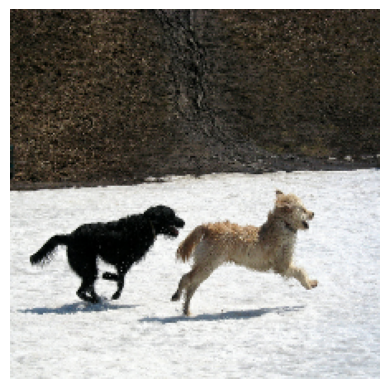

In [ ]:
# Try loading multiple images until a non-dog image is found
for img_path, cap in train_raw:
    # Decode path and load image
    path_str = img_path.numpy().decode('utf-8')
    img = load_img(path_str)

    # Optionally, use basic filtering based on filename
    if 'dogs' in path_str.lower():
        continue  # Skip if filename has 'dog' (works for many datasets like Flickr8k)

    # Generate caption
    cap_gen = captioner_model.generate_text(img[tf.newaxis, ...])
    print("Generated Caption:", cap_gen)

    # Visualize image
    plt.imshow(img / 255.0)
    plt.axis('off')
    plt.show()
    break  # Stop after first non-dog image


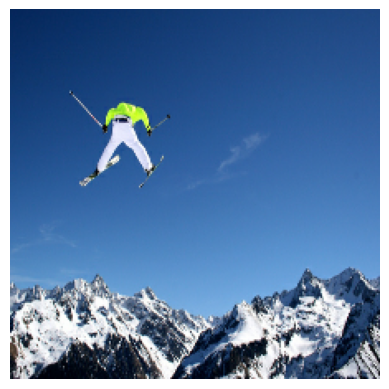

Generated Caption: a snowboarder jumping high in the air
Token count: 8
Attention scores shape: (1, 2, 8, 49)
Attention maps shape: (8, 7, 7)


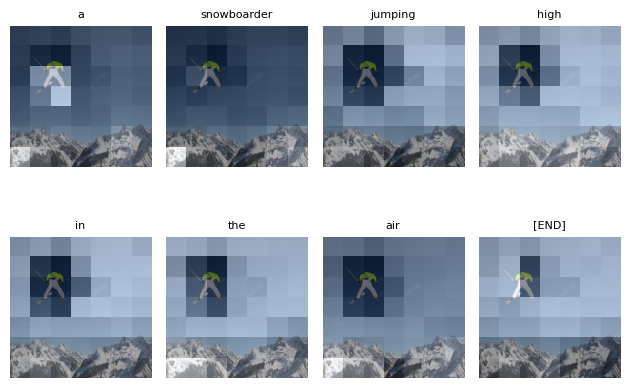

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import einops

# Take a few images from dataset
for img_paths, caps in train_raw.batch(4).skip(2).take(1):  # <-- skip(1) to avoid the first batch (dogs)
    break

# Pick the 2nd image (index 1), change to index 2/3 to visualize other ones
img_path = img_paths[1].numpy().decode('utf-8')
img = load_img(img_path)

# Show selected image
plt.imshow(img / 255.0)
plt.axis('off')
plt.show()

# Generate caption
cap_gen = captioner_model.generate_text(img[tf.newaxis, ...])
print("Generated Caption:", cap_gen)

# Tokenize the caption
cap_gen_tokens = cap_gen.split() + ['[END]']
print(f"Token count: {len(cap_gen_tokens)}")

# Attention visualization
attn_scores = captioner_model.decoder.last_attention_scores
print("Attention scores shape:", attn_scores.shape)

attn_maps = einops.reduce(attn_scores, 'b num_heads seq_len (h w) -> seq_len h w',
                          h=7, w=7, reduction='mean')
print("Attention maps shape:", attn_maps.shape)

# Plot attention maps
len_result = len(attn_maps)
col_len = int(np.ceil(len_result / 2))
row_len = 2

for i in range(len_result):
    ax = plt.subplot(row_len, col_len, i + 1)
    img_plot = ax.imshow(img / 255.0)
    plt.title(cap_gen_tokens[i], fontsize=8)
    ax.imshow(attn_maps[i], cmap='gray', alpha=0.6,
              extent=img_plot.get_extent(), clim=[0, np.max(attn_maps[i])])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# function generate_caption(image, beam_width, max_len):
#     encoder_output = CNN(image)
#     beams = [(["<start>"], 0.0)]

#     for t in range(max_len):
#         all_candidates = []

#         for seq, score in beams:
#             if seq[-1] == "<end>":
#                 all_candidates.append((seq, score))
#                 continue

#             decoder_input = tokenize(seq)
#             predictions = TransformerDecoder(encoder_output, decoder_input)
#             log_probs = log_softmax(predictions[-1])

#             top_k_words = top_k(log_probs, k=beam_width)

#             for word, log_prob in top_k_words:
#                 new_seq = seq + [word]
#                 new_score = score + log_prob
#                 all_candidates.append((new_seq, new_score))

#         if t < 3:
#             top_k_beams = select_top_k(all_candidates, beam_width)
#             chosen = random_choice(top_k_beams)
#             beams = [chosen]
#         else:
#             beams = select_top_k(all_candidates, beam_width)

#     best_caption = max(beams, key=lambda x: x[1])[0]
#     return detokenize(best_caption)

4.993715621419973
9.749521075705772
14.248970237063425
18.903719350286252
24.017883485580473
29.201891736452623
34.42353922307569
38.999147900336936
44.07366501351592
48.68010611275049
54.2186994939061
59.79594250982151
64.57420418197823
70.17100325395394
75.37962147318773
80.07885350845534
85.42363474761537
90.42778712294621
95.10843799649162
99.66466296107377
103.92941870570449
109.56600797504818
114.43921322100903
119.0616841960653
123.8269546058627
129.10946826356056
134.4505597283654
139.38200803127143
145.03940633972326
149.23431817335157
153.79076087433162
158.54986693538265
163.2914000257798
167.62336954326628
174.03679720708706
179.0268268615206
184.50773423420736
189.593709144825
194.84433975979462
199.7203584311718
204.54313016682553
210.14861393361582
214.84896480096265
219.22160249503648
224.4290232412284
230.06158781950978
234.13052017831876
238.80376627890948
243.75947702338647
248.5258138052432
253.7914248882718
258.46054189642433
263.7008005532347
269.2344104265108
273

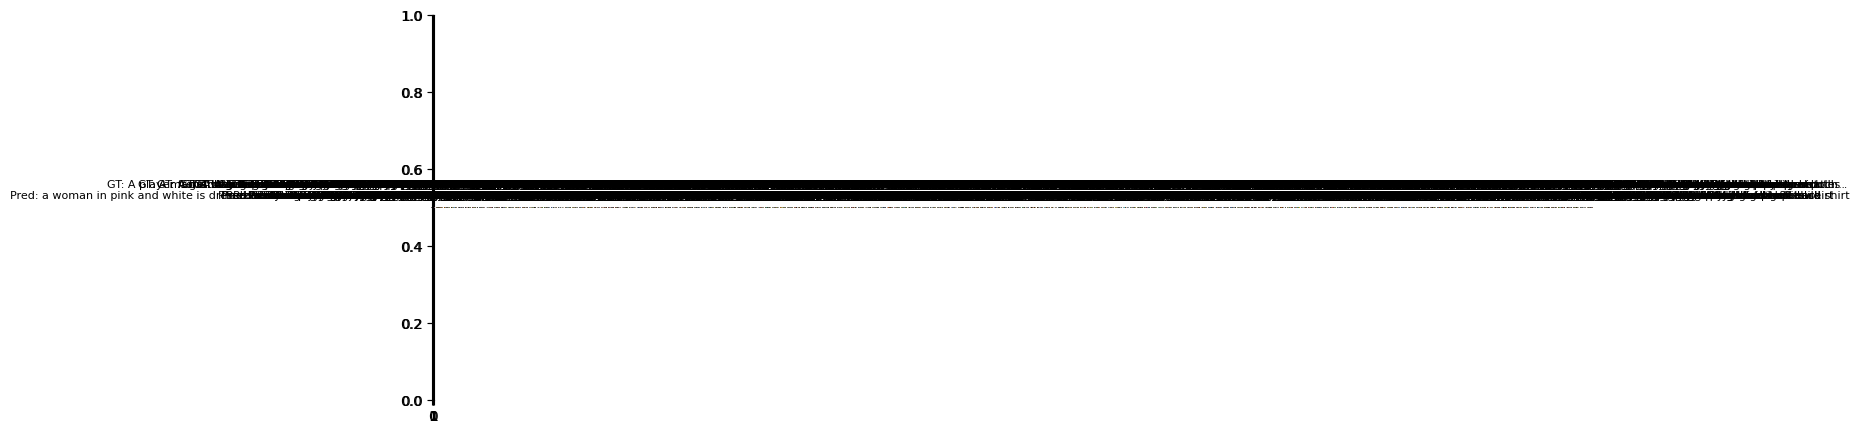

In [ ]:
import builtins
sum = builtins.sum  # Restore the built-in function
import math
from collections import Counter

def get_ngrams(sentence, n):
    """Returns a list of n-grams from a given sentence."""
    words = sentence.split()
    return [' '.join(words[i:i+n]) for i in range(len(words) - n + 1)]

def modified_precision(references, hypothesis, n):
    """Computes the modified n-gram precision."""
    hyp_ngrams = Counter(get_ngrams(hypothesis, n))
    max_ref_ngrams = Counter()

    for ref in references:
        ref_ngrams = Counter(get_ngrams(ref, n))
        for ngram in ref_ngrams:
            max_ref_ngrams[ngram] = max(max_ref_ngrams[ngram], ref_ngrams[ngram])

    # Count n-gram matches
    clipped_counts = {ngram: min(hyp_ngrams[ngram], max_ref_ngrams[ngram]) for ngram in hyp_ngrams}
    clipped_total = sum(clipped_counts.values())
    total_hyp_ngrams = sum(hyp_ngrams.values())

    if total_hyp_ngrams == 0:
        return 0  # Avoid division by zero

    return clipped_total / total_hyp_ngrams

def brevity_penalty(reference_sentences, hypothesis):
    """Computes brevity penalty to penalize short translations."""
    hyp_length = len(hypothesis.split())

    if hyp_length == 0:
        return 0  # or float('-inf') or raise an exception depending on use case

    ref_lengths = [len(ref.split()) for ref in reference_sentences]

    # Find the reference length closest to the hypothesis length
    closest_ref_length = min(ref_lengths, key=lambda ref_len: (abs(ref_len - hyp_length), ref_len))

    if hyp_length > closest_ref_length:
        return 1
    return math.exp(1 - closest_ref_length / hyp_length)

def calculate_bleu(references, hypothesis, max_n=4):
    """
    Computes the BLEU score for a generated caption against reference captions.

    Parameters:
    references (list of str): List of reference captions.
    hypothesis (str): The generated caption.
    max_n (int): Maximum n-gram order to consider (default is 4).

    Returns:
    float: BLEU score.
    """
    weights = [1.0 / max_n] * max_n  # Equal weights for up to 4-grams
    precision_scores = [modified_precision(references, hypothesis, n+1) for n in range(max_n)]

    # Compute geometric mean of precision scores
    geo_mean = math.exp(sum(w * math.log(p) for w, p in zip(weights, precision_scores) if p > 0))

    return geo_mean

# Example Usage
def find(c1, c2, c3, c4, c5, gen):
    references = [c1, c2, c3, c4, c5]  # List of reference captions
    return calculate_bleu(references, gen)


num_images = 1000
summation=0
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
a=0
for i, (img_path, caps) in enumerate(test_raw.take(num_images)):
    a=a+1
    img_path_decoded = img_path.numpy().decode('utf-8')
    img = load_img(img_path_decoded)  # Load image

    # Convert captions to strings
    caps = [cap.numpy().decode('utf-8') for cap in caps]

    # Generate caption using the model
    cap_gen = captioner_model.generate_text(img[tf.newaxis, ...])
    bleuScore=find(caps[0],caps[1],caps[2],caps[3],caps[4],cap_gen)
    summation=summation+bleuScore
    # Display image and captions
    if(a!=2 and a!=3):
      axes[i].imshow(img / 255)  # Normalize image
      axes[i].axis("off")
      axes[i].set_title(f"GT: {caps[0]}\nPred: {cap_gen}", fontsize=8)  # Show ground truth and predicted caption
    if(a%10==0):
      print(summation)
print(summation)
summation=summation
print("BLEU Score is: ")
print(summation/1000.0)

plt.show()


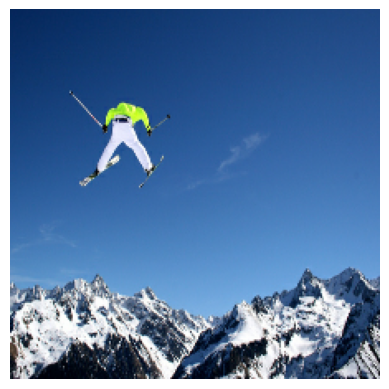

Generated Caption: a person in yellow shirt is jumping into the air


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import einops

# Take a few images from dataset
for img_paths, caps in train_raw.batch(4).skip(2).take(1):  # <-- skip(1) to avoid the first batch (dogs)
    break

# Pick the 2nd image (index 1), change to index 2/3 to visualize other ones
img_path = img_paths[1].numpy().decode('utf-8')
img = load_img(img_path)

# Show selected image
plt.imshow(img / 255.0)
plt.axis('off')
plt.show()

# Generate caption
cap_gen = captioner_model.generate_text(img[tf.newaxis, ...])
print("Generated Caption:", cap_gen)





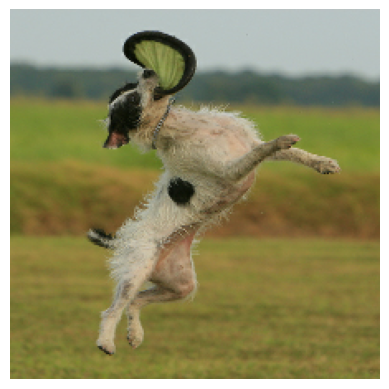

Generated Caption: a dog with a collar jumps up to catch a frisbee


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import einops

# Take a few images from dataset
for img_paths, caps in train_raw.batch(4).skip(3).take(1):  # <-- skip(1) to avoid the first batch (dogs)
    break

# Pick the 2nd image (index 1), change to index 2/3 to visualize other ones
img_path = img_paths[1].numpy().decode('utf-8')
img = load_img(img_path)

# Show selected image
plt.imshow(img / 255.0)
plt.axis('off')
plt.show()

# Generate caption
cap_gen = captioner_model.generate_text(img[tf.newaxis, ...])
print("Generated Caption:", cap_gen)





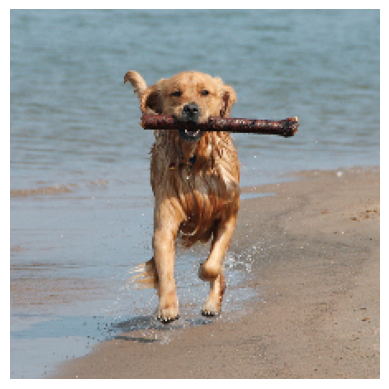

Generated Caption: a dog runs on a beach


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import einops

# Take a few images from dataset
for img_paths, caps in train_raw.batch(4).skip(5).take(1):  # <-- skip(1) to avoid the first batch (dogs)
    break

# Pick the 2nd image (index 1), change to index 2/3 to visualize other ones
img_path = img_paths[1].numpy().decode('utf-8')
img = load_img(img_path)

# Show selected image
plt.imshow(img / 255.0)
plt.axis('off')
plt.show()

# Generate caption
cap_gen = captioner_model.generate_text(img[tf.newaxis, ...])
print("Generated Caption:", cap_gen)





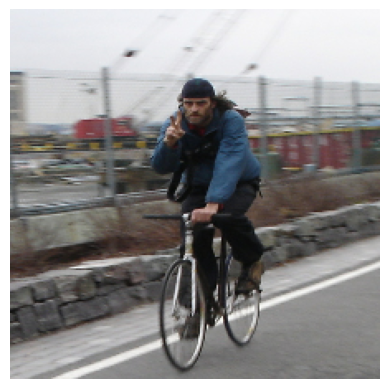

Generated Caption: a man in a blue hat is riding a bike down a street


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import einops

# Take a few images from dataset
for img_paths, caps in train_raw.batch(4).skip(9).take(1):  # <-- skip(1) to avoid the first batch (dogs)
    break

# Pick the 2nd image (index 1), change to index 2/3 to visualize other ones
img_path = img_paths[1].numpy().decode('utf-8')
img = load_img(img_path)

# Show selected image
plt.imshow(img / 255.0)
plt.axis('off')
plt.show()

# Generate caption
cap_gen = captioner_model.generate_text(img[tf.newaxis, ...])
print("Generated Caption:", cap_gen)



